# Prepare environment

This report is created from an IPython notebook which includes all the code to calculate the results.  

In [1]:
# to prepare the environment
import numpy as np
import scipy as sp
import pandas as pd
import os.path
import time
from scipy.optimize import curve_fit
from scipy import interpolate
from scipy import integrate
from scipy import signal
from scipy import ndimage
import matplotlib.pyplot as plt
import scipy.constants as const
import pickle
import itertools

import collections

%matplotlib inline

# %reload_ext autoreload
# %autoreload 2

import pyradi.ryplot as ryplot
import pyradi.ryplanck as ryplanck
import pyradi.ryfiles as ryfiles
import pyradi.rymodtran as rymodtran
import pyradi.ryutils as ryutils

from IPython.display import HTML
from IPython.display import Image
from IPython.display import display
from IPython.display import FileLink, FileLinks

import matplotlib as mpl
mpl.rc("savefig", dpi=150)
mpl.rc('figure', figsize=(10,8))
# %config InlineBackend.figure_format = 'svg'
# %config InlineBackend.figure_format = 'pdf'

pim = ryplot.ProcessImage()
pd.set_option('display.max_columns', 80)
pd.set_option('display.width', 100)
pd.set_option('display.max_colwidth', 150)

# Theoretical model

## Laser  Range Equation


This section derives the range equation for a laser target designator or range finder. Several simplifying assumptions are made in order to simplify the problem and emphasize the methodology in this first order analysis --- a more advanced analysis should follow.
The objective with this analysis is to derive an expression for the SNR for the laser designator. The  SNR can then be used to investigate the effect of several design parameters on system performance. For another approach to the range equation for laser rangefinders, see Kaminsky's paper.

### Noise equivalent irradiance
\noindent
The noise equivalent irradiance in the receiver is given by
\begin{equation}
E_n= \frac{
\sqrt{\Delta f A_d}
}{
D^\ast A_1 \tau_a
},
\label{lrfnoise}
\end{equation}
where
$A_d$ is the detector area,
$\Delta f$ is the noise bandwidth in the receiver,
$A_1$ is the receiver aperture area, and
$\tau_a$ is the receiver filter transmittance. The
$D^\ast$ values can include all of the relevant noise terms such as detector noise, amplifier noise, background induced noise, and system noise. The method whereby these noises are all combined into a single $D^\ast$ is described in [W]. For the purposes of this investigation, we will only work with a single $D^\ast$, assuming that all noise sources are incorporated in this value.


![here](images/overview.PNG)

## Signal irradiance

The geometrical relationship between the laser transmitter, the object, and the laser receiver is shown in the figure. The laser power or flux is denoted by $\Phi_L$ (in watts), the distance from the laser to the object is $R_{LO}$, and the distance from the object to the receiver is $R_{OR}$. The illuminated object-surface normal vector makes an angle $\theta_{LO}$ with the laser illumination direction, and an angle $\theta_{OR}$ with the receiver sightline direction.

The receiver and transmitter fields are not necessarily co-axial, because the receiver and transmitter are located at the same position. Different atmospheric transmittance values apply to the two optical paths.

The laser beam radiance is calculated from the  the optical power, beam area at the source and beam solid angle (divergence).  In order to use this very simple equation, the Gaussian shape properties of the laser beam is discarded for two very simple uniform shapes.
The laser beam angular radiance distribution is assumed to be uniform within the top-hat-shaped beam divergence profile (e.g., peak normalized divergence). The laser beam power distribution is assumed to be uniform across the area of the beam (e.g., peak normalized area). The radiance can be written as
\begin{equation}
L_L=\frac{\Phi_L}{\Omega_L A_L},\label{fig:laserrangeirrad}
\end{equation}
where $\Omega_L$ is the laser beam solid angle, and $A_L$ is the laser beam cross-section area at the laser source. This simplification might not satisfy the required mathematical rigor, but it does provide order-of-magnitude radiance estimates.



The irradiance on the object is then
\begin{equation}
E_O = \frac{L_L A_L \tau_{OL}\;\cos\theta_L\cos\theta_{LO}}{R^2_{LO}}
\end{equation}
\begin{equation}
E_O = \frac{\Phi_L \tau_{OL}\cos\theta_{LO}}{\Omega_L R^2_{LO}},
\end{equation}

where it is assumed that $\cos\theta_{L}=1$ because the laser beam radiates perpendicularly from the laser exit pupil. The uncooperative target object can have any orientation relative to the laser beam, denoted by $\theta_{LO}$.

## Lambertian target reflectance

The laser pulse falling onto the object is reflected by the object. Most
natural surfaces have diffuse reflectance and scatter energy in all
directions (a Lambertian source). The reflected laser spot on the target object has a radiance of

\begin{equation}
L_O=
\frac{\rho E_O}{\pi}=\frac{\rho\Phi_L \tau_{LO}\cos\theta_{LO}}{\Omega_L
\pi R^2_{LO}}
\label{loo}
\end{equation}

The irradiance, caused by the reflected pulse, at the laser receiver is then

\begin{equation}
E_R=\frac{\Phi_R}{d A_1}=\frac{L_O A_O \cos\theta_{OR}\tau_{OR}}{R_{OR}^2},
\end{equation}

where $A_O$ is the area illuminated by the laser that is visible to the
sensor. Further manipulation using Equation~\ref{loo} leads to
\begin{equation}
E_R = 
\frac{\Phi_L \tau_{LO}\cos\theta_{LO}\rho A_O \cos\theta_{OR}\tau_{OR}}
{\Omega_L \pi R^2_{OR}R^2_{LO}}
\end{equation}

\begin{equation}
E_R=
\frac{
\rho \Phi_L \tau_{LO} \cos\theta_{LO} A_O \cos\theta_{OR} \tau_{OR}
}{
\pi \Omega_L R^2_{LO}R^2_{OR}
}
\label{radar}
\end{equation}



Equation~\ref{radar} is similar to the radar range equation. The product

\begin{equation}
\rho\cos\theta_{LO} A_O \cos\theta_{OR} A_O
\end{equation}
can be regarded as the target optical cross-section. In the radar case, the optical cross section has a fixed magnitude irrespective of distance between the laser and target object. This is also true for a laser rangefinder illuminating an airborne object where there is no reflective background.  If the object is observed against a terrain background, the terrain background also contributes to the reflected signal (depending on the geometry).


## Signal to noise ratio


The rangefinder irradiance SNR is the ratio of signal strength
[Equation~\ref{radar}] to noise [Equation~\ref{lrfnoise}], and is given by
\begin{equation}
\frac{E_R}{E_n}
=\frac{
\frac{
\rho \Phi_L \tau_{LO} \cos\theta_{LO} A_O \cos\theta_{OR} \tau_{OR}\,G_\textrm{A}
}{
\pi \Omega_L R^2_{LO}R^2_{OR}
}
}{\frac{
\sqrt{\Delta f A_d}
}{
D^\ast A_1 \tau_a}
}
\end{equation}

\begin{equation}
\frac{E_R}{E_n}
=
\frac{
\rho \Phi_L \tau_{LO} \cos\theta_{LO} A_O \cos\theta_{OR} \tau_{OR}D^\ast A_1 \tau_a G_\textrm{A}
}{
\pi \Omega_L R^2_{LO}R^2_{OR}\sqrt{\Delta f A_d}
}
\end{equation}




where $G_\textrm{A}$ is the detector gain (unity for a normal photovoltaic detector and larger than one for an avalanche detector).  It is assumed here that the $D^\ast$ already accounts for the gain the detector.


The laser flux is given by $\Phi_L\approx Q_L/t_p$, where $Q_L$ is the pulse
energy in [J], and $t_p$ is the pulse width in [s]. The required receiver
electronic noise bandwidth can be written in terms of the pulse width as
$\Delta f=k_nk_f/t_p$, where
$k_n$ relates the electrical system electronic bandwidth with the noise equivalent bandwidth, and
$k_f$ relates the laser pulse width with the system electronic bandwidth.

\begin{equation}
\textrm{SNR} = \frac{E_R}{E_n}
=
\frac{
\rho Q_L \tau_{LO}\tau_{OR} \cos\theta_{LO} A_O \cos\theta_{OR} D^\ast A_1 \tau_a G_\textrm{A}
}{
\pi \sqrt{t_p k_nk_f}\Omega_L R^2_{LO}R^2_{OR}\sqrt{A_d}
}
\end{equation}

\begin{equation}
\textrm{SNR} =
\overbrace{
\left(\frac{\rho A_O \cos\theta_{LO}  \cos\theta_{OR}D^\ast}{\pi}\right)
}^{\textrm{no control}}
\overbrace{
\left(\frac{Q_L A_1 \tau_a G_\textrm{A}}{\Omega_L\sqrt{k_n k_f t_p A_d }}\right)
}^{\textrm{design}}
\overbrace{
\left(\frac{\tau_{LO}\tau_{OR}}{R^2_{LO}R^2_{OR}}\right)
}^{\textrm{distance}}
\label{lrfd2}
\end{equation}






If the laser rangefinder is viewing targets against the terrain, the laser light is reflected from the target object as well as its  surrounding terrain. This implies that the real target area is not of primary importance because the terrain background also reflects the laser pulse. Provided that the sensor field of view is larger than the laser beam spot size, note that $\Omega_L = \cos\theta_{LO} A_O/R^2_{OL}$ can the irradiance SNR now be written as

\begin{equation}
\textrm{SNR} =
\left(\frac{\rho  \cos\theta_{OR}D^\ast}{\pi}\right)
\left(\frac{Q_L A_1 \tau_a G_\textrm{A}}{\sqrt{k_n k_f t_p A_d }}\right)
\left(\frac{\tau_{LO}\tau_{OR}}{R^2_{OR}}\right)
\label{lrfd2}
\end{equation}



The detector has four quadrants, and each of these quadrants in effect is a separate detector.  The SNR is therefore given by

\begin{equation}
\textrm{SNR}_Q 
=
\left(\frac{\rho  \cos\theta_{OR}D^\ast}{\pi}\right)
\left(\frac{Q_L A_1 \tau_a G_\textrm{A}}{\sqrt{k_n k_f t_p (A_d/4) }}\right)
\left(\frac{\tau_{LO}\tau_{OR}}{R^2_{OR}}\right)
\end{equation}


\begin{equation}
\textrm{SNR}_Q 
=
\left(\frac{2 \rho  \cos\theta_{OR}D^\ast}{\pi}\right)
\left(\frac{Q_L A_1 \tau_a G_\textrm{A}}{\sqrt{k_n k_f t_p A_d }}\right)
\left(\frac{\tau_{LO}\tau_{OR}}{R^2_{OR}}\right)
\label{lrfd23}
\end{equation}





Laser guided sensors all employ quadrant detectors.  The detector shape is normally round, divided into four equal-sized, radial sector-shaped quadrants.

In the intial phases of acquisition, the laser flux may fall only on a single quadrant: detection.  After initial acquisition, when tracking the target, the (defocused) laser flux is spread approximately equal between the four quadrants.
Hence, when considering the requirement to track the spot, the beam flux must be divided by four to obtain the signal strength on one detector.
This means that the SNR per quadrant will be

\begin{equation}
\textrm{SNR}_Q
=
\left(\frac{2\rho  \cos\theta_{OR}D^\ast}{\pi T}\right)
\left(\frac{Q_L A_1 \tau_a G_\textrm{A}}{\sqrt{k_n k_f t_p A_d }}\right)
\left(\frac{\tau_{LO}\tau_{OR}}{R^2_{OR}}\right)
\label{lrfd3}
\end{equation}
where $T=1$ for detection and $T=4$ for tracking.

Equation~\ref{lrfd3} describes the laser designator system signal to noise ratio.
There are three groups of variables:



1. Variables and constants that the designer has no control over, such as the object orientation and reflectivity, $D^\ast$, and constants.

2. Variables that the designer controls in the design process, such as laser energy, receiver aperture area, laser pulse width, and detector size.

3. Distance-related factors that the designer has little control over.


The designer can now easily determine that increased laser energy and receiver aperture improves the SNR linearly, whereas increased detector area and pulse width decrease the SNR. Contrary to intuition, a longer pulse width (i.e., a lower electronic bandwidth) decreases the SNR. Why?

An estimate of the detection range can be obtained by solving for the range $R_{OR}$ in Equation~\ref{lrfd3}, where SNR is the signal-to-noise ratio required to achieve detection or tracking. 

If the laser divergence is small, the laser spot will almost always be smaller than the sensor field of view.  Under this condition, the system performance is relatively insensitive to the range between the laser source and the target.  Note that the laser-target range $R_{LO}$ appears only in the numerator in the transmittance term $\tau_{LO}$ --- there is no $1/R^2$ losses in the laser propagation: all the flux remains visible to the sensor.  

On the other hand, the range from the sensor to the target $R_{OR}$ appears explicitly in the denominator as $R^2_{OR}$ and implicitly the numerator in the transmittance term $\tau_{OR}$.  The system performance is therefore highly sensitive to the sensor-target distance.


In [2]:
# to calculate the SNR given all system parameters and ranges

def SNRvsRange(rho, thetaOR, Dstar, Ql, radiusoptics, taua, taul, taus,
                    kn, kf, tp, ad, lrange, srange, omode, detectorgain):
    A1 = np.pi*(radiusoptics)**2
    num = 2.0 * rho * np.cos(thetaOR) * Dstar * Ql * A1 * taua * taul * taus * detectorgain
    T = 1.0 if 'Detection' in omode else 4.0
    den = T * np.pi * np.sqrt(kn * kf * tp * ad) * (srange) **2
    return num / den

## SNR considerations

### Laser rangefinder and radar detection performance

The performance of this class of applications depends relatively strongly on the temporal shape of individual instances of the signal. Each pulse is a unique and independent event. 
The calculation of  the probability of detection and false alarm rate requires information about the peak signal, rms noise, and threshold setting. The general  solutions for arbitrary pulse shapes, noise spectra, and nonlinear detection processes are very complex and are not considered here. If the signal is a square pulse, filtered by a matched filter, and the input noise is white with a Gaussian distribution, as is the case for most natural noises, the detection performance can be readily calculated. This is a special case, but, is useful to obtain at least an order of magnitude indication. 

The detection of a square pulse of width $t_p$, immersed in white noise after passing through a matched filter with bandwidth $\Delta f=1/(2 t_p)$, is shown graphically in the figure below. Detection is the event where the signal corrupted by noise exceeds the detection threshold. A false alarm is the event where the noise (with no signal present) exceeds the detection threshold.
The average false alarm rate is given by
\begin{equation}
FAR=
\frac{1}{2  t_p \sqrt{3}}\exp^{-\frac{1}{2}\left(\frac{i_t}{i_n}\right)^2}
\end{equation}
where
$i_t$ is the threshold value, and
$i_n$ is the rms noise value at the input to the threshold detector.  The probability of false alarm is 
\begin{equation}
P_f = {FAR\, t_p}=
\frac{1}{2 \sqrt{3}}\exp^{-\frac{1}{2}\left(\frac{i_t}{i_n}\right)^2},
\end{equation}

When there is a signal present, the probability of detection (signal plus noise exceeds the threshold) is given by
\begin{equation}
P_d \approx
\frac{1}{2}\left[
1+{\textrm{erf}}\left(
\frac{i_s-i_t}{\sqrt{2}i_n}
\right)
\right]
\end{equation}
where ${\textrm{erf}}$ is the error function:
\begin{equation}
{\textrm{erf}}(z)=\frac{2}{\sqrt{\pi}}\int_0^z e^{-t^2}dt.
\end{equation}

![noiseprob](images/noiseprob01.png)

For a given combination of threshold value $i_t$, noise value $i_n$, and signal value $i_s$, the average false alarm rate and probability of detection can be determined. Alternatively, for a given required false alarm rate or probability of detection, the threshold-to-noise ratio and SNR can be determined. These equations can be solved numerically or graphically.

**Note that the Rice model desribed above is derived for a square detector and a matched filter (time-bandwidth product of 0.5).**  Different pulse shapes and time-bandwidth products technically invalidates the simple model used here.  It remains however a rough guide at to order-of-magnitude performance.

As an example of the application of these formulae, consider the following
problem in the Electro-Optics Handbook The SNR and threshold-to-noise ratio  (TNR) for a laser rangefinder must be found. The laser pulses are 100~ns wide. A range gate of 67~$\mu$s is used. One in 1000 pulses may be lost, and a false alarm detection of 1 in 1000 pulses is required.  The solution is as follows:



1.  
The false alarm performance must be 1 per 1000 pulses, each pulse arriving in a 67-$\mu$s window. The false alarm rate must therefore be less than $1/(1000 \times 67 \times 10^{-6})=15$ pulses per second.

1.   $t_p {FAR} =0.1\times 10^{-6}\times 15=1.5\times
10^{-6}$.

1.   The TNR is calculated as
\begin{equation}
\frac{i_t}{i_n}=\sqrt{-2\log_e\left(2 t_p \sqrt{3}\;{FAR}\right)}=4.93
\end{equation}

1.  The SNR is given by
\begin{equation}
\frac{i_s}{i_n}=\sqrt{2}\;{\textrm{erf}}^{-1}\left(2P_d-1\right)+\frac{i_t}{i_n},
\end{equation}
requiring a SNR of 8.023.

1.  The equations can be solved by the pyradi implementation of these equations. 



In [3]:
# to calculate the TNR and SNR for the laser rangefinder example

pulsewidth = 100e-9
ProbFA = 1e-3
rangegate = 67e-6
FAR = ProbFA / rangegate
probDetection = 0.999
ThresholdToNoise = ryutils.detectThresholdToNoiseTpFAR(pulsewidth,FAR)
SignalToNoise = ryutils.detectSignalToNoiseThresholdToNoisePd(ThresholdToNoise, probDetection)
print('For a laser pulse with width={0}, a FAR={1} and Pd={2},'.format(pulsewidth,FAR,probDetection))
print('the Threshold to Noise ratio must be {0}'.format(ThresholdToNoise))
print('and the Signal to Noise ratio must be {0}'.format(SignalToNoise))
print(' ')


For a laser pulse with width=1e-07, a FAR=14.925373134328359 and Pd=0.999,
the Threshold to Noise ratio must be 4.934081407207049
and the Signal to Noise ratio must be 8.024313713374863
 



In a range finder the detection of a pulse in a wrong time slot is a false detection.  The range resolution is ultimately given by the pulse width, so the pulse width determines the false alarm rate. Combined with the range gate, the FAR determines the probability of false alarm.

Missle laser pulse detection is fundamentally different from range finder pulse detection.   The exact time of arrival of the pulse does not determine the false alarm performance of the system.  The false alarm performance is determined by the probability of simultaneous noise pulses in the one/four quadrants that could constitute a valid signal, while detecting/tracking.  So in detection mode each quadrant is considered separately and the probability of system false alarm condition is four times the probability of quandrant false alarm.
In tracking mode the requirement is that a sufficiently large signal must be present, simultaneously in all four quadrants; effectively the quadrant probability of false alarm to the fourth power.

For this analysis the worst case, detection, is considered.  The graph below shows the probability of detection for different threshold to noise and signal to noise ratios.  The legend in the graph shows the threshold to noise ratio, the probability of false alarm, and the number of frames between false alarm.  In the calculation a missile frame time of 10 ms is assumed.

It is evident that for a threshold to noise ratio of three, a false detection occurs once every 78 frames. This is acceptably low to work on the assumption of a threshold to noise ratio of less than three. For a threshold to noise ratio of three and a signal to noise ratio of five the probability of detection is 97.7%, which is quite high for this application.

Modern missiles and radars have intelligence to control the threshold to noise ratio as well as the detection logic.  These systems dynamically control the threshold to noise ratio such as to maintain a constant false alarm rate. The objective is to have noise-riding or a clutter-riding threshold that provides the best detection performance in a given condition.  Furthermore these systems employ M-out-of-N logic to improve the detection performance and guard against false alarms.

Based on this analysis a signal to noise ratio of five is considered a reasonable and safe assumption in the context of this investigation.

SNR=5.00, TNR=2.00, Pd=0.999
SNR=5.00, TNR=2.50, Pd=0.994
SNR=5.00, TNR=3.00, Pd=0.977


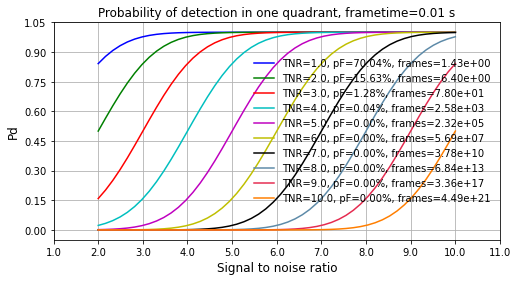

In [4]:
TNRs = np.linspace(1,10,10)
SNRs = np.linspace(2,10,50)
tw = 0.01
quadrants = 4
 
p = ryplot.Plotter(1,1,1,figsize=(8,4))
for TNR in TNRs:
    FAR = ryutils.detectFARThresholdToNoisepulseWidth(TNR,tw )
    pF = quadrants * FAR * tw
    pD = ryutils.detectProbabilityThresholdToNoiseSignalToNoise(TNR, SNRs)
    p.plot(1, SNRs, pD,'Probability of detection in one quadrant, frametime={} s'.format(tw),
           'Signal to noise ratio','Pd',
           label=['TNR={}, pF={:.2f}%, frames={:.2e}'.format(TNR, 100*pF,1/(pF) )])

for tnr in [2, 2.5, 3]:    
    snr = 5
    pdet = ryutils.detectProbabilityThresholdToNoiseSignalToNoise(tnr, snr)
    print('SNR={:.2f}, TNR={:.2f}, Pd={:.3f}'.format(snr, tnr, pdet))


Final and further motivation for the chosen signal to noise ratio of five stems from the author's experience in missile seeker design and analysis over a career of 35 years. During this time he designed and evaluated several missile seekers from simple reticle designs to advanced imaging seekers. He never worked on laser tracking seekers, though.  
This SNR=5 approach was confirmed over the years in discussions with other missile seeker designers in Europe and Russia.  Finally, the system engineer of the A-Darter seeker was consulted on 2016-03-09 and he confirmed that SNR=5 is a very reasonable value.
As a result of all this work he considers a signal to noise ratio of five to be typical in the industry and likely to apply to laser trackers as well.


## Sensor field of view

The detector field of view is related to the detector size, focal length and f-number with the following relationships. We assume a circular field of view and detector shape.  The full-apex field of view is $\theta$, the detector diameter is $d$, focal length is $f$, sensor aperture diameter is $D$ and f-number is $F_\sharp$.

\begin{equation}
\tan\left(\frac{\theta}{2}\right) = \frac{d}{2f}
\end{equation}

\begin{equation}
F_\sharp = \frac{f}{D}
\end{equation}

\begin{equation}
d = 2 F_\sharp D \tan\left(\frac{\theta}{2}\right)
\end{equation}




## Turbulence and scintillation

This model does not account for turbulence or scintillation effects.


## Atmospheric transmittance models

### Horizontal paths

The atmospheric attenuation coefficients at the laser wavelength of 1.06~$\mu$m are taken from page 89 of the RCA Electro-Optics Handbook (also known as the Burle Electro-Optics Handbook).  These values apply to a homogeneous atmosphere at sea level.
For a homogeneous atmosphere the Beer law is used for atmospheric transmittance $\tau = \exp(-\gamma R)$.

Note that the simple example given here only models atmospheric scattering.  At 1.064 $\mu$m the atmospheric absorption is small and not considered.

![here](images/rcaeohb-p89.PNG)

In [5]:
gammas = 0.02 * 10 ** (np.asarray([28.5, 43.8, 63, 79.5, 102, 118.5, 138]) / 83.5) * 1e-3
visib = ['Exceptionally clear 60 km vis', 'Very clear 50 km vis', 'Standard clear 23.5 km  vis',
        'Clear 15 km vis', 'Light haze 8 km vis', 'Medium haze 5 km vis', 'Haze 3 km vis',  ]
viskms = [60., 50., 23.5, 15., 8., 5., 3.]
dicGammas = {viskm: visib[i] for i,viskm in enumerate(viskms)}
dfGammas = pd.DataFrame.from_dict(dicGammas, orient='index')
dfGammas.columns = ['ADefinition']
dfGammas['viskm'] = dfGammas.index
dfGammas.sort_index(inplace=True, ascending=False)
dfGammas['gamma'] = gammas
print(dfGammas)

                        ADefinition  viskm     gamma
60.0  Exceptionally clear 60 km vis   60.0  0.000044
50.0           Very clear 50 km vis   50.0  0.000067
23.5    Standard clear 23.5 km  vis   23.5  0.000114
15.0                Clear 15 km vis   15.0  0.000179
8.0             Light haze 8 km vis    8.0  0.000333
5.0            Medium haze 5 km vis    5.0  0.000525
3.0                   Haze 3 km vis    3.0  0.000899


In [6]:
# to plot horizontal path transmittance
p = ryplot.Plotter(1,1,1,figsize=(12,6));
pathl = np.linspace(0,20,100)
for viskm in dfGammas.index:
    row = dfGammas.ix[viskm]
    atau = np.exp(- pathl * 1e3 * row['gamma'])
    p.plot(1,pathl, atau,'Horizontal path transmittance for selected atmospheres',
          'Range km','Transmittance',label=[row['ADefinition']])

AttributeError: 'DataFrame' object has no attribute 'ix'

### Slant paths

A number of 'standard' atmospheres were defined to cover the expected range of climatic conditions to be used in design analyses and optimisations.   More information is available in the repository at <http://ezstash.opmain.ds.corp/projects/TAPM/repos/nv-ipm-models/browse/Atmospheres/Standard>.  The ground height for all atmospheric models is at sea level. 
The paths were calculated from the stated altitude at a slant angle of 45 deg down to earth (zenith angle of 135 degrees), at a number of fixed altitudes.  

The 'Generic Atmosphere' calculations recalculated the path radiance for the different ambient temperatures.  The calculations for the standard atmospheres are done very differently: the calculations are done once, for each atmospheric scenario, according to the temperature for that specific atmosphere.  Path radiance and atmospheric transmittance are used with no adaptation at the ranges calculated in Modtran.

The atmospheric temperature varies with altitude, hence the sensor will also be cooler at higher altitudes.  The calculation takes into account the temperature rise of the internal sensor parts above the ambient atmospheric conditions outside the sight.

The model descriptions and altitudes are as follows:

#### ExtremeHotLowHumidity
__very hot, low humidity, 75 km Desert visibility - no wind, clear day in the desert__  
User model (36 layers), 70 km visibility  Desert aerosol, ground level P=1030~mbar, T=44C, RH=30%, 18.1~g/m$^3$  absolute humidity. 

#### ExtremeHumidity:
__very high humidity - Arabian gulf, tropical Africa / Amazon__  
User model (36 layers), 23 km visibility  Rural aerosol, ground level P=1030~mbar, T=35C, RH=95%, 37.9~g/m$^3$ absolute humidity. 
At sea level, this atmosphere corresponds with  the highest recorded dew point at 34~$^\circ$C.  MIL-HDBK-310 indicates that the probability of absolute humidity exceeding this level is significantly less than 1\%. This corresponds to the highest recorded humidity ever, recorded in Sharjah in the UAE.

#### MidLatMaritimeSummer:
__Mediterranean coastal summer day good visibility__  
Mid-Latitude Summer, 23 km visibility  Maritime aerosol, ground level P=1012~mbar, T=21C, RH=76%, 14~g/m$^3$ absolute humidity. 

#### MidLatMaritimeWinter:
__Mediterranean coastal winter day poor visibility__  
Mid-Latitude Winter, 10 km visibility  Maritime aerosol, ground level P=1018~mbar, T=-1C, RH=77%, 3~g/m$^3$ absolute humidity. 

#### ScandinavianSummer:
__Scandinavian summer day, windy conditions__  
Sub-Arctic Summer, 31 km visibility  Navy Maritime aerosol (wind speed 20 m/s, 24 hr ave 8 m/s), ground level P=1010~mbar, T=14C, RH=75%, 9~g/m$^3$ absolute humidity. 

#### ScandinavianWinter:
__Scandinavian winter day, windy conditions__  
Sub-Arctic Winter, 31 km visibility  Navy Maritime aerosol (wind speed 20 m/s, 24 hr ave 8 m/s), ground level P=1010~mbar, T=-15.9C, RH=80%, 1~g/m$^3$ absolute humidity. 

#### TropicalDesert:
__Moderate temperature, 75 km Desert visibility - no wind, clear day in the desert__  
Tropical, 75 km visibility  Desert aerosol, ground level P=1013~mbar, T=26.5C, RH=75%, 18.8~g/m$^3$ absolute humidity. 

#### TropicalRural:
__Moderate temperature, 23 km Rural visibility__  
Tropical, 23 km visibility  Rural aerosol, ground level P=1013~mbar, T=26.5C, RH=75%, 18.8~g/m$^3$ absolute humidity. 

#### TropicalUrban:
__Moderate temperature, 5 km Urban visibility__  
Tropical, 5 km visibility  Urban aerosol, ground level P=1013~mbar, T=26.5C, RH=75%, 18.8~g/m$^3$ absolute humidity. 

#### USStdNavyMarVis23km:
__Moderately Low temperature, moderate humudity, 23 km Navy Maritime visibility__  
US Standard, 23 km visibility  Navy Maritime aerosol, ground level P=1013~mbar, T=15C, RH=46%, 5.9~g/m$^3$ absolute humidity.  Windspeed of 7.4 m/s corresponds to a Beaufort sea state 4.


In [ ]:
# to define the standard atmospheres in the AOSA repository
#altitudes  (in m)
alts = [305, 1524, 3048, 4572, 6096, 7620, 9144, 10668, 12192, 13716, 14326, 15240]

#standard atmospheres: code: decription
atmospheres = {
    u'ExtremeHotLowHumidity':['44 C, 30% RH 77 km Vis Desert',44.],
    u'ExtremeHumidity'      :['35 C, 95% RH 23 km Vis Rural',35.], 
    u'MidLatMaritimeSummer' :['21 C, 76% RH 23 km Vis Maritime',21.], 
    u'MidLatMaritimeWinter' :['-1 C, 77% RH 10 km Vis Maritime',-1.], 
    u'ScandinavianSummer'   :['14 C, 75% RH 31 km Vis Maritime',14.], 
    u'ScandinavianWinter'   :['-15.9 C, 80% RH 31 km Vis Maritime',-15.9],
    u'TropicalDesert'       :['26.6 C, 75% RH 75 km Vis Desert',26.6], 
    u'TropicalRural'        :['26.6 C, 75% RH (23 km Vis Rural',26.6],
    u'TropicalUrban'        :['26.6 C, 75% RH 5 km Vis Urban',26.6],
    u'USStdNavyMarVis23km'  :['15 C, 46% RH 23 km Vis Nav.Mar',15.0],
    }

atmodefStd = [(s,atmospheres[s],float(atmospheres[s][0].split()[0])) for s in  atmospheres.keys()]

#each base tape5 file is in its own repo directory, according to the atmo code
dirs = atmospheres.keys()

atmodef = pd.DataFrame.from_dict(atmospheres, orient='index')
atmodef.reset_index(level=0, inplace=True)
atmodef.columns = ['atmo','ADefinition','Temp']


The following code loads the Modtran tape7 files and extract the transmittance at the laser wavelength for the different paths in the various atmospheres.  


In [ ]:
# to load the atmospheric data
#get a list of all the files, on the path to where the repository is checked out
fileslist = ryfiles.listFiles(root=r'..\..\nv-ipm-models\Atmospheres\Standard', 
                patterns=r'.*tape7', recurse=1, return_folders=0, useRegex=True)

dfStdAtmoCols = ['Atmosphere', 'Altitude', 'PathLen', 'wl', 'TauAtmo']
dfStdAtmo = pd.DataFrame(columns=dfStdAtmoCols)

wlNdYag = 1.064
wnNdYag = 1e4 / wlNdYag

for i,filename in enumerate(fileslist):
    if 'elev' not in filename:
        filesplit = filename.split('\\')
        vprofilename = os.path.join(*(filesplit[:-2]+['{}-profile.txt'.format(filesplit[-3])]))
        vprofile = np.loadtxt(vprofilename)
        altkm = float(filesplit[-2])/1000.
        atmoTempAltK = np.interp(altkm, vprofile[:,0], vprofile[:,2])
        colselect = ['FREQ', 'TOT_TRANS']
        tape7 = rymodtran.loadtape7(filename, colselect )
        #interpolate to the wn/wl vector used in the calcs further down
        TauAtmo = np.interp(wnNdYag, tape7[:,0], tape7[:,1])
        #at this point we have, for a given atmo and alitude, the spectral vector, transmittance and path radiance

        dfStdAtmo = dfStdAtmo.append(pd.DataFrame([[filesplit[-3], altkm,
                                                    np.sqrt(2.)*float(filesplit[-2])/1000., wlNdYag, TauAtmo]],
                                                   columns=dfStdAtmoCols))
pathLensStd = dfStdAtmo['PathLen'].unique()
atmoStd = dfStdAtmo['Atmosphere'].unique()

The following plot shows the slant path transmittance  from sea level at a 45-degree slant angle.  It is evident that most of the attenuation takes place in the bottom two to three km layer of the atmosphere.

In [ ]:
# to plot slant path transmittance
p = ryplot.Plotter(1,1,1,figsize=(12,6))
for atmo in atmoStd:
    dfilter = (dfStdAtmo['Atmosphere']==atmo) 
    df = dfStdAtmo[dfilter].sort_values(by='PathLen')
    srange = df['PathLen'] 
    taul = df['TauAtmo']
    p.plot(1,srange,taul,'Slant path transmittance for the standard atmospheres',
           'Slant range km','Transmittance',label=[atmo],pltaxis=[0,25,0,1])
    

## Background flux

The background flux in the scene determines the detector current, which in turn determines  the noise in the detector. If the sensor is operating at night, the detector noise is at a minimum. If the sensor is pointed at a bright, sunlit background, the current and hence the noise in the detector increases relative to the dark night condition.    

The reflected sunlight model developed in 'Electro-Optical System Analysis and Design' by C J Willers provides a quick and convenient means to calculate the radiance of reflected sunlight.  Typical background radiance values are as follows, calculated for a 45-degree slant path and for an atmospheric transmittance of 0.65 at the laser wavelength.

In [ ]:
# to calculate reflected background flux radiance

atau = 0.65
sangle = np.pi * 45. / 180. # rad
refl = np.linspace(0,1,100)
radce = atau * refl * np.cos(sangle) * 2.17e-5 * ryplanck.planck([1.064], 5800, 'el') / np.pi
p = ryplot.Plotter(1,1,1,figsize=(12,4));
p.plot(1, refl, radce,'Background radiance vs reflectance','Diffuse reflectance',
       'Radiance W/(m$^2\cdot$sr$\cdot\mu$m)');

The values provided in 'Range calculations for IR rangefinder and designators', W R Kaminski, SPIE Vol 227, 1980 are as follows:

|Terrain  | Background radiance|
|---|----|
|Dark night   | 0|
|Grass terrain | 10  |
|Snow terrain | 100 |
|Blue sky | 10|
|Dark clouds | 8
|Sunlit clouds | 100|
|  | W/(m$^2\cdot$sr$\cdot\mu$m)|

The radiance value for brightly lit snow or sidelit clouds confirms a reflectance of around unity --- as could be expected.  The radiance value for a grass terrain seems very low, implying a diffuse reflectance of 0.1.  


The background radiance values are used to calculate the current in the detector.  Once the current in the detectors were known, the shot noise at the respective currents were calculated, and finally, new $D^\ast$ values were calculated.  These new $D^\ast$ values now represent the noise performance of the sensor under the various background conditions. Once the new $D^\ast$ values were known, the range performance corresponding to the different conditions were determined.


Ignoring all noise in the detector, the photon signal still contains noise.  Background limited performance (BLIP) operation is the condition where the detector noise is zero, and only the background signal limits performance.  In this investigation the BLIP performance for 'Dark night', ' Grass terrain', and 'Snow terrain' is considered.  The background flux levels for these three conditions are given in the table above.

The background limited $D^\ast_{\lambda}$ depends on the scene radiance and is given by 
\begin{equation}
D^\ast_{\textrm{BLIP}} = \frac{\lambda\eta_\lambda}
{hc\sqrt{2 \int_0^{\lambda_c}\eta_\lambda E_q d \lambda}}
\end{equation}
where
$\eta_\lambda$ is the spectral quantum efficiency and 
$E_q$ is the photon irradiance on the detector.  Assuming a constant quantum efficiency over the band of interest, the equation becomes

\begin{equation}
D^\ast_{\textrm{BLIP}} =\frac{\lambda\sqrt{\eta}}
{hc\sqrt{2 \int_{\lambda_1}^{\lambda_2} E_q d \lambda}}
=
\frac{\lambda\sqrt{\eta}}
{hc\sqrt{2 \Omega \int_{\lambda_1}^{\lambda_2} L_q d \lambda}}
\end{equation}
where $\Omega$ is the solid angle of the exit pupil as viewed from the detector and $\lambda_1$ and $\lambda_2$ define the lower and upper limits of the spectral band.

The optics exit pupil solid angle is given by
\begin{equation}
\Omega = \pi\sin^2\theta = \pi(NA)^2 = \frac{\pi}{(2F_\sharp)^2}
\end{equation}
where $\theta$ is the half apex angle of the f-number cone.

Hence

\begin{equation}
D^\ast_{\textrm{BLIP}} 
=
\frac{\lambda F_\sharp\sqrt{2\eta}}
{hc\sqrt{ \pi \int_{\lambda_1}^{\lambda_2} L_q d \lambda}}
\end{equation}

Given that the spectral band is narrow and the spectral photon irradiance does not vary significantly over the band

\begin{equation}
D^\ast_{\textrm{BLIP}} 
=
\frac{\lambda F_\sharp\sqrt{2\eta}}
{hc\sqrt{ \pi\, \Delta\lambda \,L_{q\lambda}}}
\end{equation}
where $\Delta\lambda = \lambda_2 - \lambda_1 $

The effective detector $D^\ast$, containing both the detector noise and the background flux noise, is then 

\begin{equation}
\frac{1}{(D^\ast_\textrm{eff})^2}
=
\frac{1}{(D^\ast_\textrm{dark})^2}
+
\frac{1}{(D^\ast_\textrm{BLIP})^2}
\label{lab:effdeestar}
\end{equation}



## Surface diffuse reflection

The target reflection at the laser wavelength varies significantly between different materials.  The diffuse reflectance used in this investigation is 0.4, motivated on the grounds of an average of all the data presented in this section. The chosen value corresponds with construction materials (cement and concrete) and natural materials (sand and dry vegetation) that are neither too dark nor too bright.

The present study does not investigate the effect of specular reflectors.

The spectral reflectance values are as follows:

In [ ]:
# read the excel spreadsheet containing the AOSA spectral reflectance database
xfilename = 'data/Target reflectivities.xlsx'
dfRefl = pd.read_excel(xfilename, 'Refl', index_col=None, skip_footer=7, na_values=['NA'])
dfRefl.drop(labels=['Sky(Day)'], axis=1, inplace=True)
dfReflcols = list(dfRefl.columns.values)
p = ryplot.Plotter(1,1,1,figsize=(12,5));
p.plot(1,dfRefl['Lambda'], dfRefl[dfReflcols[1:]].as_matrix(),'Spectral reflectance AOSA database',
       'Wavelength $\mu$m','Reflectance',label=dfReflcols[1:]);


The  Aster  (<http://speclib.jpl.nasa.gov/>) spectral library has a number of spectral reflectance data sets, some of which are plotted below:

![' '](images/reflectance-Aster.png)


A considerable volume of data are given in a thesis 'Visible near infrared (VNIR) and shortwave infrared (SWIR) spectral variability of urban materials'', Kenneth G.Fairbarn, Naval Postgraduate School, Monterey, California, 2013.  The thesis is available here: 
<http://www.nps.edu/academics/centers/rsc/documents/13mar_fairbarn_kenneth.pdf>

![' '](images/reflectance-concrete.png)

![' '](images/reflectance-diverse.PNG)


# Performance Prediction

## Sensor definitions

The sensor parameters used in this study are shown below. All values are given in base SI units: Joule, metre, rad, as appropriate.

The graphs are not included for all the different sensor variations, only selected cases are shown.  All results are however displayed in tabular form and are also available in an Excel spreadsheet.

In [ ]:
# read the excel spreadsheet containing the sensor data and extract the example data

xfilename = 'data/laser-sys-params.xlsx'

rfilename = 'data/laser-sys-params-{}.xlsx'.format('results')

print('Input file: {}\n  created:       {}\n  last modified: {}'.format(xfilename,
                    time.ctime(os.path.getctime(xfilename)),
                    time.ctime(os.path.getmtime(xfilename))))

dfS = pd.read_excel(xfilename, 'Sheet1', index_col=None, na_values=['NA'])
dfS.set_index(keys='Index',inplace=True)
dfS.drop(labels=[-1],  inplace=True)
# get rid of empty lines
dfS.dropna(inplace=True)
#rearrange to calc new rows, as columns
dfS = dfS.transpose()
dfS['FOVrad'] = np.pi * dfS['FOVdeg'] / 180.
dfS['foclen'] = dfS['Fno'] * 2. * dfS['radiusoptics']
dfS['diaDetector'] = 2. * dfS['Fno'] * 2. * dfS['radiusoptics'] * np.tan(dfS['FOVrad'].astype('float')/2.)
dfS['areaDetector'] = np.pi * (dfS['diaDetector']/2.)**2
dfS['filtdeltalam'] = dfS['filtdeltalam'].astype(np.float)

writer = pd.ExcelWriter(rfilename)
dfS.to_excel(writer,'Systems')
dfSx = dfS.copy()
dfSx['system'] = dfSx.index

# back to original orientation
dfS = dfS.transpose()
print(dfS)


Using Equation~\ref{lab:effdeestar} now calculate the effective $D^\ast$ for the three background conditions, the sensor optics geometry and the spectral filter bandwidth.  In the code the $D^\ast$ is calculated for all six different background scenarios, but only the first three (the terrain backgrounds) will be used in this analysis.

In [ ]:
# to calculate the Dstar for the different scene background flux levels 
dfST = dfS.transpose().copy()

# the three cases considered (see the table in the text)
dstlabels = ['Dark night','Grass terrain','Snow terrain','Blue sky','Dark clouds','Sunlit clouds']
leback = np.asarray([1e-100, 10., 100., 10., 8., 100.]).reshape(-1,1) # W/(m2.sr.um)

# convert from radiant units to quantum rate units
wlambda = dfST['lambda'].astype(np.float).reshape(1,-1)
lqback = np.array(leback * wlambda * 1e-6/ (6.6e-34 * 3e8))# q/(s.m2.sr.um)

# calculate dstar blip for different backgrounds, 100 converts to cm units
num = 100. * dfST['lambda'].astype(np.float) * 1e-6 * dfST['Fno'].astype(np.float)**2 \
         * np.sqrt(2. * dfST['quantumEff'].astype(np.float) * dfST['detectorGain'].astype(np.float))
den =  6.6e-34 * 3e8 * np.sqrt(np.pi * dfST['filtdeltalam'].astype(np.float).reshape(1,-1) * lqback)
dstarblip =  pd.DataFrame(num.reshape(1,-1) / den, columns=dfS.columns.values,
                         index = dstlabels)
print('Dstar BLIP units cm.sqrt(Hz)/W')
print(dstarblip)
print(' ')
dstars = 1.0/ np.sqrt(1.0/dfST['Dstar'].astype(np.float)**2 + 1.0/dstarblip**2.)
print('Dstar effective units cm.sqrt(Hz)/W')
print(dstars)

dstars.T.to_excel(writer,'Dstars')


## Horizontal Paths

In [ ]:
# to plot laser energy on target for horizontal paths

laserEs = dfS.T['Ql'].unique()[1:-1]

p = ryplot.Plotter(1,len(laserEs),1,figsize=(12,12));

pathl = np.linspace(0,20,100)
arr = pathl.reshape(-1,1)
cols = []
cols.append('Range')
for ilE,laserE in enumerate(laserEs):
    p.resetPlotCol()
    for viskm in dfGammas.index:
        row = dfGammas.ix[viskm]
        atau = np.exp(- pathl * 1e3 * row['gamma'])
        p.plot(1+ilE,pathl, 1e3 * laserE * atau,'Laser energy on target: {} mJ laser'.format(1e3*laserE),
              'Range km','Energy mJ',label=[row['ADefinition']])
        arr = np.hstack((arr, np.asarray(1e3 * laserE * atau).reshape(-1,1)))
        cols.append(row['ADefinition'])
      
    dfhe = pd.DataFrame(arr,columns=cols)
    dfhe.to_excel(writer,'Horizontal-path-Energy-{}mJ'.format(1e3*laserE))


In [ ]:
# to plot the results for one system

def SNRvsRangeHor(dfS, dfSNR, ipl, system, srange, lrange, gammas, visib, viskms,omode):
    dfSys = dfS[system]

    srangefud = np.flipud(srange.reshape(-1,1)).reshape(-1,) / 1e3

    dstlabels = ['Dark night','Grass terrain','Snow terrain']
    if dfSys['plot'] >0:
        p = ryplot.Plotter(ipl,3,1,figsize=(10,16))
        
    for i,dstlabel in enumerate(dstlabels):
        dstar = 0.01 * dstars.ix[dstlabel][system] #convert dstar to m
        if dfSys['plot'] >0:
            p.resetPlotCol()
        for vis,gamma, viskm in zip(visib,gammas, viskms):
            taul = np.exp(-lrange * gamma)
            taus = np.exp(-srange * gamma)
            SNR = SNRvsRange(rho=dfSys['rho'], thetaOR=dfSys['thetaOR'], 
                                  Dstar=dstar, Ql=dfSys['Ql'], radiusoptics=dfSys['radiusoptics'], 
                                  taua=dfSys['taua'], taul=taul, taus=taus,
                                  kn=dfSys['kn'], kf=dfSys['kf'], tp=dfSys['tp'], 
                                  ad=dfSys['areaDetector'], 
                                  lrange=lrange,srange=srange,omode=omode,
                                  detectorgain=dfSys['detectorGain']).reshape(-1,1)
            SNRud = np.flipud(SNR).reshape(-1,)
            trange = np.interp(dfSys['SNR'], SNRud, srangefud ) 
            gltrange = np.interp(trange, srangefud, taul ) * np.interp(trange, srangefud, taus ) / trange ** 2
             
            dfSNR = dfSNR.append(pd.DataFrame([[system,dstlabel,viskm,dfSys['SNR'], trange, gltrange,omode]], 
                                              columns=dfSNR.columns.values))

            if dfSys['plot'] >0:
                title = '{} {}: {:.0f} mJ, sensor: {} m {} deg {}, D*={:.1e} SNR={}'.format(system, omode, 
                                dfSys['Ql']*1e3,2.*dfSys['radiusoptics'],dfSys['FOVdeg'],dstlabel,dstar*100.,
                                dfSys['SNR'])
                p.semilogY(1+i,srange/1e3, SNR,title,'Distance km','SNR',
                           label=['{} $\gamma$={:.2f} km$^{{-1}}$ [{} {:.1f} km]'.format(vis,
                                            gamma * 1e3,omode,trange)], 
                           pltaxis=[0, dfSys['maxRangeHor']/1e3, 1, 100])        

    return dfSNR

In [ ]:
# to plot horizontal path results

snrColumns = ['system','dstlabel','viskm','SNR','distance','geo-losses','omode']
dfSNR = pd.DataFrame(columns=snrColumns)

for ipl,system in enumerate(dfS.columns.values):
    #set max range for calcs
    srange = np.linspace(10, dfS[system]['maxRangeHor'], 100)
    lrange = srange
    
    for opl,omode in enumerate(['Detection','Tracking']):
        dfSNR = SNRvsRangeHor(dfS, dfSNR, opl+len(dfS.columns.values)*ipl, 
                system, srange, lrange, gammas, visib, viskms,omode)    
dfSNR.to_excel(writer,'Horizontal-SNR')
 

The graphs above shows the detection and tracking ranges different atmospheric and terrain conditions.  The label for each line describes the atmospheric condition, the attenuation coefficient and the estimated range where tracking would commence.

Note that these paths are horizontal at sea level, so these conditions are much more stringent than for slant paths from high altitudes.

The tables below contains the detection and tracking distances, for the prescribed signal to noise ratios (see the value of the SNR in the sensor definition above).


In [ ]:
# to display detection and tracking ranges in tabular format

dfSNRA = pd.merge(left=dfSNR,right=dfGammas, left_on='viskm', right_on='viskm')
dfSNRB = pd.merge(left=dfSNRA,right=dfSx, left_on='system', right_on='system')

dfSNRB = dfSNRB[pd.notnull(dfSNRB['distance'])]

dstlabelUs = dfSNRB['dstlabel'].unique()
viskmUs = dfSNRB['viskm'].unique()
rhoUs = dfSNRB['rho'].unique()
radiusopticsUs = dfSNRB['radiusoptics'].unique()

ptb = pd.pivot_table(dfSNRB, values='distance', index=['dstlabel','viskm','ADefinition','Ql'], columns=['omode']).copy()
    
ptb = ptb.reset_index()

for jplt,(rho,radiusoptics) in enumerate(list(itertools.product(rhoUs,radiusopticsUs))):

    ptitle = 'Tracking distance for horizontal paths: refl={}, optics={} m'.format(rho, 2*radiusoptics)
    p = ryplot.Plotter(jplt,1,3,figuretitle=ptitle,figsize=(12,5))
    for iplot, dstlabelU in enumerate(dstlabelUs):
        p.resetPlotCol()
        for viskmU in viskmUs:
            filt = (dfSNRB.dstlabel==dstlabelU) & (dfSNRB.omode=='Tracking') & \
                    (dfSNRB.rho==rho) & (dfSNRB.viskm==viskmU) & \
                    (dfSNRB.radiusoptics==radiusoptics)
            df = dfSNRB[filt]
            ptitle = '{}'.format(dstlabelU)
            p.plot(iplot+1, df.Ql*1e3, df.distance,ptitle,'Laser energy mJ','Tracking distance km',
                   label=[df.ADefinition.unique()[0]],pltaxis=[20, 100, 0, 25],maxNX=7)
ptb.to_excel(writer,'Horizontal-distance-vs-energy')


In [ ]:
# to display detection and tracking ranges in tabular format

dfSNRA = pd.merge(left=dfSNR,right=dfGammas, left_on='viskm', right_on='viskm')
systemUs = dfSNR['system'].unique()

ptb = pd.pivot_table(dfSNRA, values='distance', index=['dstlabel','viskm','ADefinition'], columns=['system','omode'])

for systemU in systemUs:
    print('\n--------------------------------------------------\n ')
    print(systemU)
    print(ptb[systemU])
    ptb[systemU].to_excel(writer,'Horizontal-{}'.format(systemU))
  

The following graphs show the estimated detection and tracking distances versus visibility for the different systems in the different conditions. Note that this information pertains to horizontal paths.


In [ ]:
# to plot range vs visibiliy
systemUs = dfSNR['system'].unique()
dstlabelUs = dfSNR['dstlabel'].unique()
SNRs = dfSNR['SNR'].unique()
omodes = dfSNR['omode'].unique()

# snrColumns = ['system','dstlabel','viskm','SNR','distance']

for iplt, systemU in enumerate(systemUs):
    ptitle = '{}: {:.0f} mJ, sensor: {} m {} deg SNR={}'.format(systemU, 
                  1e3*dfS[systemU]['Ql'],2*dfS[systemU]['radiusoptics'],dfS[systemU]['FOVdeg'],
                                                        dfS[systemU]['SNR'])
    p = ryplot.Plotter(iplt,1,3,ptitle, figsize=(12,3))
    
    for kplt,omode in enumerate(omodes):
        
        for jplt,dstlabelU in enumerate(dstlabelUs):
            
            filt = (dfSNR.system==systemU) & (dfSNR.dstlabel==dstlabelU) & (dfSNR.omode==omode)

            #get intended set only
            df = dfSNR[filt].copy()   
            lab = '{}'.format(omode)
            p.plot(jplt+1,df['viskm'],df['distance'],dstlabelU,'Visibility km','Distance km',label=[lab],
                  plotCol=p.plotCol[kplt], pltaxis=[0,60,0,dfS[systemU]['maxRangeHor']/1e3],maxNX=5)



## Slant paths


In [ ]:
# to plot laser energy on target for slant paths

laserEs = dfS.T['Ql'].unique()[1:-1]

p = ryplot.Plotter(1,len(laserEs),1,figsize=(12,12));

for ilE,laserE in enumerate(laserEs):
    p.resetPlotCol()
    for iatmo,atmo in enumerate(atmoStd):
        dfilter = (dfStdAtmo['Atmosphere']==atmo) 
        df = dfStdAtmo[dfilter].sort_values(by='PathLen')
        srange = df['PathLen'] 
        taul = df['TauAtmo']
        p.plot(ilE+1,srange,1e3 * laserE * taul,'Slant path laser energy on target: {} mJ laser'.format(1e3*laserE),
               'Slant range km','Energy mJ',label=[atmo])
        if ilE==0 and iatmo==0:
            arr = srange.reshape(-1,1)
            cols = ['Slant range']
        arr = np.hstack((arr,taul.reshape(-1,1)))
        cols.append(atmo)
    dfhe = pd.DataFrame(arr,columns=cols)
    print(dfhe)
    dfhe.to_excel(writer,'Slant-path-Energy-{}mJ'.format(1e3*laserE))
        
    

In [ ]:
# to plot the results for one system for slant path scenarios

def plotSNRvsRangeslant(dfS, dfSNR, ipl, system, atmoStd, pathLensStd,omode):
    dfSys = dfS[system]

    dstlabels = ['Dark night','Grass terrain','Snow terrain']

    if dfSys['plot'] >0:
        p = ryplot.Plotter(ipl,3,1,figsize=(10,16))
    for i,(dstlabel,dstar) in enumerate(zip(dstlabels,dstars)):
        dstar = 0.01 * dstars.ix[dstlabel][system] #convert dstar to m
        if dfSys['plot'] >0:
            p.resetPlotCol()
        for atmo in atmoStd:
            dfilter = (dfStdAtmo['Atmosphere']==atmo) 
            df = dfStdAtmo[dfilter].sort_values(by='PathLen')
            srange = df['PathLen'] * 1e3
            lrange = srange
            srangefud = np.flipud(srange.reshape(-1,1)).reshape(-1,) / 1e3
            taul = df['TauAtmo']
            taus = taul            

            SNR = SNRvsRange(rho=dfSys['rho'], thetaOR=dfSys['thetaOR'], 
                                  Dstar=dstar, Ql=dfSys['Ql'], radiusoptics=dfSys['radiusoptics'], 
                                  taua=dfSys['taua'], taul=taul, taus=taus,
                                  kn=dfSys['kn'], kf=dfSys['kf'], tp=dfSys['tp'], 
                                  ad=dfSys['areaDetector'], 
                                  lrange=lrange,srange=srange,omode=omode,
                                  detectorgain=dfSys['detectorGain']).reshape(-1,1)
    
            SNRud = np.flipud(SNR).reshape(-1,)
            trange = np.interp(dfSys['SNR'], SNRud, srangefud ) 
            
            dfSNR = dfSNR.append(pd.DataFrame([[system,dstlabel,atmo,dfSys['SNR'], trange,omode]], 
                                              columns=dfSNR.columns.values))

            if dfSys['plot'] >0:            
                title = '{}: {:.0f} mJ, sensor: {} m {} deg {}, D*={:.1e} SNR={}'.format(system, dfSys['Ql']*1e3,
                                                       2.*dfSys['radiusoptics'],dfSys['FOVdeg'],dstlabel,dstar*100.,dfSys['SNR'])
                p.semilogY(1+i,srange/1e3, SNR,title,'Distance km','SNR',
                           label=['{} [{} {:.1f} km]'.format(atmo,omode,trange)],pltaxis=[0,25,1,100])
            
    return dfSNR    

The graphs below plots the signal to noise ratio versus distance for the different systems and the different terrain conditions.

It is evident that the two atmospheres with low visibility result in significantly lower signal to noise ratios, and therefore smaller distances.

In [ ]:
# to plot SNR for different atmospheres and terrains

snrColumns = ['system','dstlabel','atmo','SNR','distance','omode']
dfSNR = pd.DataFrame(columns=snrColumns)

for ipl,system in enumerate(dfS.columns.values):
    for opl,omode in enumerate(['Detection','Tracking']):
        dfSNR = plotSNRvsRangeslant(dfS, dfSNR, opl+len(dfS.columns.values)*ipl, 
                                    system, atmoStd, pathLensStd,omode) 
dfSNR.to_excel(writer,'Slant-SNR')

        

The following table shows the tracking distance versus laser energy for different atmospheric conditions.
Note that distances are capped at approx 21.5km by the range of input atmospheric data.  Also keep in mind that these graphs do not consider the DRI performance at the given distances: the operator may very well not even see the target, hence, some of these performance points are not physically relevant.  A more detailed analysis should combine this info with the DRI range performance under similar conditions.
Nevertheless, for slant paths increasing the laser power does give longer ranges (because the atmospheric transmittance is better).

In [ ]:
# to plot distance versus laser energy

dfSNRA = pd.merge(left=dfSNR,right=atmodef, left_on='atmo', right_on='atmo')
dfSNRA.drop('Temp', axis=1, inplace=True)
dfSNRB = pd.merge(left=dfSNRA,right=dfSx, left_on='system', right_on='system')
dfSNRB = dfSNRB[pd.notnull(dfSNRB['distance'])]

# print(dfSNRB)

dstlabelUs = dfSNRB['dstlabel'].unique()
atmoUs = dfSNRB['atmo'].unique()
rhoUs = dfSNRB['rho'].unique()
radiusopticsUs = dfSNRB['radiusoptics'].unique()

ptb = pd.pivot_table(dfSNRB, values='distance', index=['dstlabel','atmo','ADefinition','Ql'], columns=['omode']).copy()
ptb = ptb.reset_index()
# print(ptb)

for jplt,(rho,radiusoptics) in enumerate(list(itertools.product(rhoUs,radiusopticsUs))):

    ptitle = 'Tracking distance for slant paths: refl={}, optics={} m'.format(rho, 2*radiusoptics)
    p = ryplot.Plotter(jplt,1,3,figuretitle=ptitle,figsize=(14,6))
    for iplot, dstlabelU in enumerate(dstlabelUs):
        p.resetPlotCol()
        for atmoU in atmoUs:
            filt = (dfSNRB.dstlabel==dstlabelU) & (dfSNRB.omode=='Tracking') & \
                    (dfSNRB.rho==rho) & (dfSNRB.atmo==atmoU) & \
                    (dfSNRB.radiusoptics==radiusoptics)
            df = dfSNRB[filt]
            ptitle = '{}'.format(dstlabelU)
            p.plot(iplot+1, df.Ql*1e3, df.distance,ptitle,'Laser energy mJ','Tracking distance km',
                   label=[df.ADefinition.unique()[0]],pltaxis=[20, 100, 0, 25],maxNX=7)

ptb.to_excel(writer,'Slant-distance-vs-energy')
            

The following table shows the detection and tracking ranges against the different atmospheres and terrain conditions.  

In the tables below the maximum range is limited to 21.55 km by the available atmospheric data --- the correct range estimate should exceed this limit.

In [ ]:
# to display SNR in tabular format

dfSNRA = pd.merge(left=dfSNR,right=atmodef, left_on='atmo', right_on='atmo')
dfSNRA.drop('Temp', axis=1, inplace=True)

ptb = pd.pivot_table(dfSNRA, values='distance', index=['dstlabel','atmo','ADefinition'], columns=['system','omode'])
for systemU in systemUs:
    print('\n--------------------------------------------------\n ')
    print(systemU)
    print(ptb[systemU])
    ptb[systemU].to_excel(writer,'Slant-{}'.format(systemU))


In [ ]:
# to close the Excel file
writer.save()


# Conclusion

Tracking range distance calculations were made for a series of laser energy levels and sensor aperture diameters.  Three scenarios were considered: dark night (no background), grass terrain (normal background) and snow terrain (very bright background). The calculations predict detection (all laser flux on a single quadrant) and tracking (laser flux spread across all four quadrants) accounting for horizontal and slant paths under various atmospheric conditions. In all the cases considered the designator and sensor were co-located (i.e., at the same range on the same vector from the target).  

The system performance is less adversely affected by designator range and hence designator ranges can be further out and still achieve acceptable performance.  The range between the sensor and the target has a far bigger impact on operating range, than does range to the designator.

The expected operating ranges depend on the sensor design parameters. For all the results shown here the sensor full apex field of view is nine degrees, optics diameter is 50 mm with f-number 1.4, optical transmittance 0.8, and filter spectral width 30 nm.

Horizontal path atmospheric variations varied visibility from very poor (3 km) to very good(60 km). 
Slant path atmospheric conditions varied from Scandinavian (-16 C), to extreme heat (44 C), and extreme humidity (35C 95%RH). Visibility ranged from 5 km (very poor urban aerosol) to 77 km (very fine desert aerosol).


## Horizontal paths

For horizontal paths the calculations indicated that for a 40 mJ to 50 mJ laser, a 14 km *tracking range* is only achievable under exceptionally clear to very clear conditions (visibility 50 km to 60 km) against dark to grassy backgrounds. Under the same conditions the spot can be *single-quadrant-detected* for visibilities better than about 40 km.  
Compared to the 40 mJ laser, the 50 mJ laser gives approximately 1000 m further *tracking range* under these good atmospheric conditions (but less benefit for lower visibility atmospheres).

For horizontal paths the calculations indicated that for a 80 mJ laser, a 14 km *tracking range* is only achievable under very clear conditions (visibility exceeding 50 km) against dark to grassy backgrounds. Under the same conditions the spot can be *single-quadrant-detected* for visibilities better than 23 km.  
Compared to the 40 mJ laser, the 80 mJ laser gives approximately 3000 m further *tracking range* under exceptionally clear atmospheric conditions (but less benefit for lower visibility atmospheres).

For horizontal paths the calculations indicated that for a 100 mJ laser, a 14 km tracking range is only achievable under very clear conditions (visibility better than about 40 km) against dark to grassy backgrounds. Under the same conditions the spot can be *single-quadrant-detected* for visibilities better than 23 km.  
Compared to the 40 mJ laser, the 100 mJ laser gives approximately 4000 m to 5000 m further *tracking range* under exceptionally clear atmospheric conditions (but less benefit for lower visibility atmospheres).



## Slant paths


For slant paths the calculations indicated that for a 40 mJ to 50 mJ laser, a 14 km *tracking range* is achievable for all atmospheres against a dark night and grass terrain.  Against a brightly lit snow terrain the tracking distance is 12 km for a 40 mJ laser and 13-14 km for a 50 mJ laser. The 50 mJ laser fails only against a 5 km visibility atmosphere against a bright snow background.  This is an impossible condition, because a 5 km visibility scenario will not have such a bright sunlit snow brightness.
Under all conditions the spot can be *single-quadrant-detected* at ranges exceeding 21 km.

For slant paths the calculations indicated that for the 80 mJ and 100 mJ lasers, a 14 km *tracking range* is achievable for all atmospheres, even the brightly sunlit snow terrain.  
Under all conditions the spot can be *single-quadrant-detected* at ranges exceeding 21 km.




# Python and [module versions, and dates](http://nbviewer.ipython.org/github/jrjohansson/scientific-python-lectures/blob/master/Lecture-0-Scientific-Computing-with-Python.ipynb)

In [ ]:
%load_ext version_information
%version_information numpy, scipy, matplotlib